### Import modules

In [2]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import selectivesearch
import matplotlib.patches as mpatches
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras import backend as K
from keras.losses import sparse_categorical_crossentropy, categorical_crossentropy, mean_squared_error
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import Input, Dense, BatchNormalization, Concatenate, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from IPython.display import SVG

### Load Dataset

In [3]:
dataset = np.load('hyf_data.npy')
X = dataset.copy()

#### Function to plot the images

In [4]:
def plot_images(images, face_label = None, gender_label = None):
    fig, axes = plt.subplots(3, 6, figsize=(20,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if face_label is not None and gender_label is not None:
            face = 'Face' if face_label[i][0] else 'No Face'
            gender = 'Male' if np.array_equal(gender_label[i], [1, 0]) else 'Female' if np.array_equal(gender_label[i], [0, 1]) else 'No Face'
            shape = 'Shape: ' + str(images[i].shape)
            xlabel = face +'\n'+ gender + '\n' + shape
        else:
            shape = 'Shape: ' + str(images[i].shape)
            xlabel = shape
        ax.set_xlabel(xlabel)        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### Plot image data

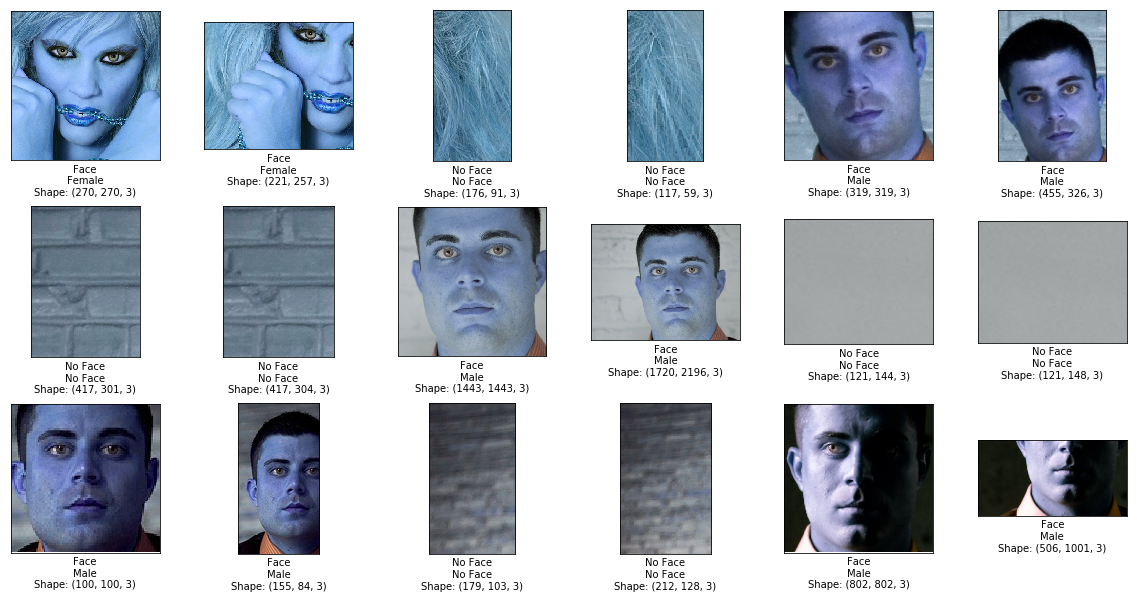

In [5]:
plot_images(images=X[:18,0], face_label=X[:18,1], gender_label = X[:18,5])

### Creating and resizing training data

In [6]:
def resize_images_to_227_x_227(images):
    images = images / 255
    return np.array([scipy.misc.imresize(im, (227,227)) for im in X[:,0]])

def get_data_and_print_shapes():
    X_train = resize_images_to_227_x_227(X[:, 0])
    print("training data shape: ", X_train.shape)

    # You can change the array in the second element from [1, 1] to [1] and [0, 0] to [0] .
    y_Face = np.array([face[0] for face in X[:, 1]])
    print("Face label shape: ", y_Face.shape)

    y_Landmarks = np.array([mark for mark in X[:, 2]])
    print("Landmarks label shape: ", y_Landmarks.shape)


    y_Visibility = np.array([visible for visible in X[:, 3]])
    print("Visibility label shape: ", y_Visibility.shape)

    y_Pose = np.array([pose for pose in X[:, 4]])
    print("Pose label shape: ", y_Pose.shape)

    y_Gender = np.array([1 if np.array_equal(gender, [1, 0]) else 0 if np.array_equal(gender, [0, 1]) else 2 for gender in X[:, 5]])
    y_Gender = to_categorical(y_Gender)[:,:-1]
    print("Gender label shape: ", y_Gender.shape)
    return X_train, y_Face, y_Landmarks, y_Visibility, y_Pose, y_Gender

In [7]:
X_train, y_Face, y_Landmarks, y_Visibility, y_Pose, y_Gender = get_data_and_print_shapes()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


training data shape:  (391, 227, 227, 3)
Face label shape:  (391,)
Landmarks label shape:  (391, 42)
Visibility label shape:  (391, 21)
Pose label shape:  (391, 3)
Gender label shape:  (391, 2)


### Plot resized image data

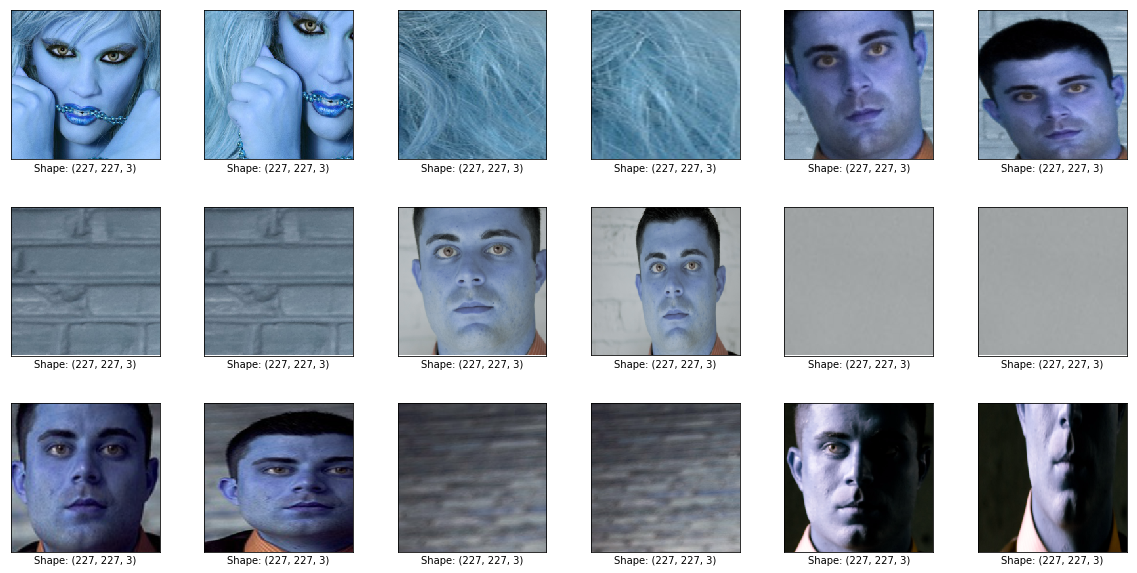

In [8]:
plot_images(images=X_train[:18])

###  Create Face Detection Network

In [38]:
def create_rcnn_face_detection_network():
        inputs = Input(shape=(227, 227, 3), name='input_tensor')
        # First Convolution
        conv1 = Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu',
                       name='conv1')(inputs)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(conv1)
        pool1 = BatchNormalization(name = 'batch_norm_1')(pool1)
        
        # Second Convolution
        conv2 = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu',
                       name='conv2')(pool1)
        pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool2')(conv2)
        pool2 = BatchNormalization(name = 'batch_norm_2')(pool2)
        
        # Third Convolution
        conv3 = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                       name='conv3')(pool2)
        conv3 = BatchNormalization(name = 'batch_norm_3')(conv3)
        
        # Fourth Convolution
        conv4 = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                       name='conv4')(conv3)
        conv4 = BatchNormalization(name = 'batch_norm_4')(conv4)
        
        # Fifth Convolution
        conv5 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                       name='conv5')(conv4)
        pool5 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(conv5)
        pool5 = BatchNormalization(name = 'batch_norm_5')(pool5)
        
        # Flatten the output of fifth covolution part
        flatten = Flatten(name='flatten')(pool5)

        # Fully connected with 4096 units
        fully_connected = Dense(4096, activation='relu', name='fully_connected')(flatten)

        # Fully connected with 512 units
        face_detection = Dense(512, activation='relu', name='detection')(fully_connected)

        # Face detection output with 2 units
        face_output = Dense(2, name='face_detection_output')(face_detection)

        model = Model(inputs=inputs, outputs=face_output)

        model.compile(Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

### Selective search function to return the candidate regions from the image 

In [39]:
def selective_search(img, plot_image = False):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, sigma=0.9, min_size=100)
    candidates = set()
    for r in regions:
        x, y, w, h = r['rect']
        candidates.add(r['rect'])
    if plot_image:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        ax.imshow(img)
        for x, y, w, h in candidates:
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=3)
            ax.add_patch(rect)
        plt.show()
    return candidates

### Intersection Over Union Implementation

In [40]:
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

### Function to calculate bottom right coordinates of the image from width and height of the candidate region

In [33]:
def get_xy(box):
    x,y,w,h = box
    x_top_left = x
    y_top_left = y
    x_right_bottom = x_top_left + w
    y_right_bottom = y_top_left + h
    return [x_top_left, y_top_left, x_right_bottom, y_right_bottom]

##### This function fetches the region from images and return only those regions having IOU greater than some threshhold (0.5) and resize the region to (227 X 227)

In [34]:
def region_of_proposals(image):
    candidates = selective_search(image, True)   
    selected_regions = list()
    boxA = [0, 0,image.shape[0], image.shape[1]]
    for candidate in candidates:
        boxB = get_xy(candidate)
        iou = intersection_over_union(boxA, boxB)
        if iou >= 0.5:
            selected_regions.append(candidate)
    # resize according to alexnet input and return selected regions
    image = image / 255
    return np.array([scipy.misc.imresize(image[r[0]:r[3], r[1]:r[2],:], (227, 227)) for r in selected_regions])

### Show the output of region of proposals in image and prints the number of selected regions

/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


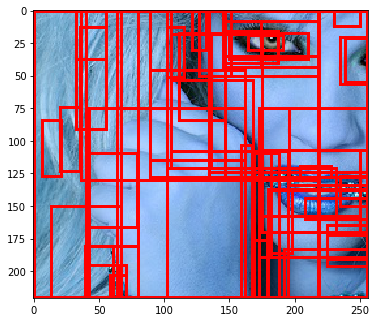


3 regions are selected with IOU greater than 0.5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


In [35]:
rops = region_of_proposals(X[:,0][1])
print('\n' + str(rops.shape[0]) + ' regions are selected with IOU greater than 0.5')

### Plot the selected regions from the image

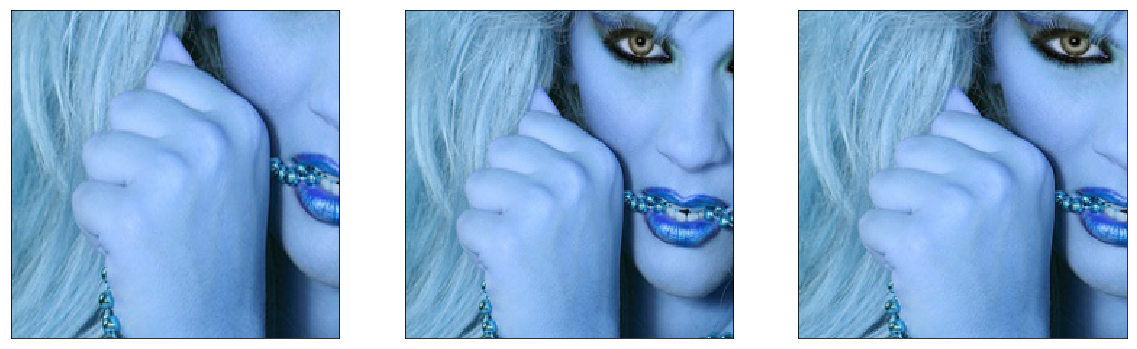

(3, 227, 227, 3)


In [36]:
def plot_rops(rop):
    fig, axes = plt.subplots(1, rop.shape[0], figsize=(20,20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(rop[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
plot_rops(rops)
print(rops.shape)


### Face RCNN Callbacks

In [37]:
def face_rcnn_callbacks():
    path_checkpoint = 'face_rcnn_checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=1,
                                          save_weights_only=True, save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    log_dir = 'face_rcnn_logs'
    callback_tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)
    return [callback_checkpoint, callback_early_stopping, callback_tensorboard]

### Train or load the Face detection model

In [43]:
# Training here is done using actual image, but it should be trained on region images prepared in above step.
model_save_file = 'face_model.h5'
exists = os.path.isfile(model_save_file)
if not exists:
    face_model = create_rcnn_face_detection_network()
    callbacks = face_rcnn_callbacks()
    face_model.fit(x=X_train, y=y_Face, batch_size=32, epochs=2, callbacks = callbacks)
    face_model.save(model_save_file)
else:
    face_model = load_model(model_save_file)

Epoch 1/2
391/391 [==============================] - 117s 299ms/step - loss: 1.1712 - acc: 0.5857
Epoch 2/2


/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


391/391 [==============================] - 105s 268ms/step - loss: 0.6931 - acc: 0.5166


### Face model sumary

In [44]:
face_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tensor (InputLayer)    (None, 227, 227, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 27, 27, 96)        0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 27, 27, 96)        384       
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 13, 256)       0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 13, 13, 256)       1024      
__________

### Face R-CNN Model Graph 

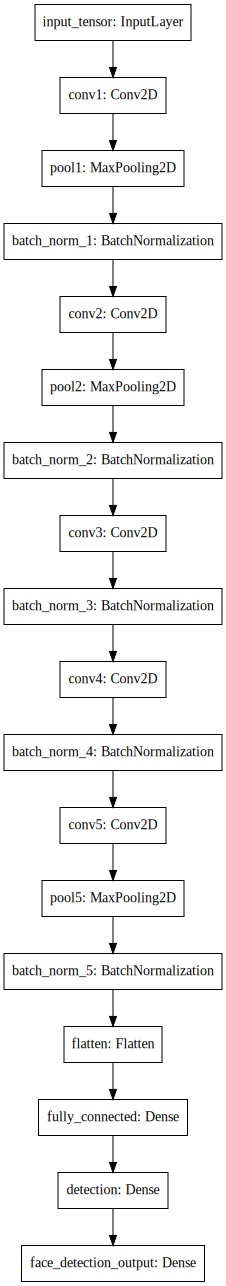

In [45]:
SVG(model_to_dot(face_model).create(prog='dot', format='svg'))

### Expand the visibility labels to use it in creating custom loss for landmark detection
for example: visibility is 1 for (x, y) point, with this method it will convert (1,1) for (x,y)

In [46]:
def expanded_visibility(y_Visibility):
    expand_visibility = np.tile(np.expand_dims(y_Visibility, axis=2), [1, 1, 2])
    return np.reshape(expand_visibility, [expand_visibility.shape[0], -1])

### Custom loss for landmark localization

In [47]:
class LocalizationCustomLoss:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.cur_index = 0

    def custom_localization_loss(self, visibility):
        visibility = K.variable(visibility[self.cur_index:self.cur_index + self.batch_size, :])
        self.cur_index += self.batch_size

        def wrapper_loss(y_true, y_pred):
            return K.mean(visibility * K.square(y_pred - y_true), axis=-1)

        return wrapper_loss

In [48]:
visibility = expanded_visibility(y_Visibility)
custom_loss = LocalizationCustomLoss(batch_size=32)
localization_loss = custom_loss.custom_localization_loss(visibility)

### Hyperface Network

In [57]:
def create_hyperface_network():
    input = Input(shape=(227, 227, 3), name='input')

    # First Convolution
    conv1 = Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu',
                   name='conv1')(input)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(conv1)
    pool1 = BatchNormalization(name = 'batch_norm_1')(pool1)
    
    # Extracting low-level details from poo11 layer to fuse (concatenate) it later
    conv1a = Conv2D(filters=256, kernel_size=(4, 4), strides=(4, 4), activation='relu', name='conv1a')(pool1)
    conv1a = BatchNormalization(name = 'batch_norm_1a')(conv1a)
    
    # Second Convolution
    conv2 = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu',
                   name='conv2')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(conv2)
    pool2 = BatchNormalization(name = 'batch_norm_2')(pool2)
    
    # Third Convolution
    conv3 = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                   name='conv3')(pool2)
    conv3 = BatchNormalization(name = 'batch_norm_3')(conv3)
    
    # Extracting mid-level details from conv3 layer to fuse (concatenate) it later with high-level pool5 layer.
    conv3a = Conv2D(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='valid', activation='relu',
                    name='conv3a')(conv3)
    conv3a = BatchNormalization(name = 'batch_norm_3a')(conv3a)
    
    # Fourth Convolution
    conv4 = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                   name='conv4')(conv3)
    conv4 = BatchNormalization(name = 'batch_norm_4')(conv4)
    
    # Fifth Convolution
    conv5 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                   name='conv5')(conv4)
    pool5 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(conv5)
    pool5 = BatchNormalization(name = 'batch_norm_5')(pool5)
    
    # Fuse (concatenate) the conv1a, conv3a, pool5 layers
    concat = Concatenate(axis=-1, name='concat_layer')([conv1a, conv3a, pool5])
    concat = BatchNormalization(name = 'batch_norm_concat')(concat)
    
    # Add convolution to reduce the size of concatenated layers
    conv_all = Conv2D(filters=192, kernel_size=(1, 1), strides=(1, 1), padding='valid', name='conv_all')(concat)

    # Flatten the output of concatenated layer with reduced filters to 192
    flatten = Flatten(name='flatten_layer')(conv_all)

    # Fully connected with 3072 units
    fc_full = Dense(3072, activation='relu', name='fully')(flatten)

    # Split the network into five separate branches with 512 units from fc_full
    # corresponding to the different tasks.
    detection = Dense(512, activation='relu', name='face_detection')(fc_full)
    landmarks = Dense(512, activation='relu', name='landmarks')(fc_full)
    visibility = Dense(512, activation='relu', name='visibility')(fc_full)
    pose = Dense(512, activation='relu', name='pose')(fc_full)
    gender = Dense(512, activation='relu', name='gender')(fc_full)

    # Face detection output with 2 units
    face_output = Dense(2, name='face_detection_out')(detection)
    # Landmark localization output with 42 units
    landmarks_output = Dense(42, name='landmarks_output')(landmarks)
    # Landmark visibility output with 21 units
    visibility_output = Dense(21, name='visibility_output')(visibility)
    # Pose output with 3 units
    pose_output = Dense(3, name='pose_output')(pose)
    # Gender output with 2 units
    gender_output = Dense(2, name='gender_output')(gender)

    model = Model(inputs=input, outputs=[face_output, landmarks_output, visibility_output, pose_output, gender_output])
    
    # These losses will be added in keras at the time of optimization
    loss = {'face_detection_out': sparse_categorical_crossentropy, 'landmarks_output': localization_loss,
            'visibility_output': mean_squared_error, 'pose_output': mean_squared_error, 'gender_output': categorical_crossentropy}
    
    loss_weights = {'face_detection_out': 1, 'landmarks_output': 5, 'visibility_output': 0.5, 'pose_output': 5, 'gender_output': 2}
    model.compile(Adam(lr=0.0001), loss = loss , loss_weights = loss_weights, metrics=['accuracy'])
    return model

In [58]:
hyperface_model = create_hyperface_network()

### Hyperface model sumary

In [59]:
hyperface_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 55, 55, 96)   34944       input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 27, 27, 96)   0           conv1[0][0]                      
__________________________________________________________________________________________________
batch_norm_1 (BatchNormalizatio (None, 27, 27, 96)   384         pool1[0][0]                      
__________________________________________________________________________________________________
conv2 (Con

### Hyperface Model Graph

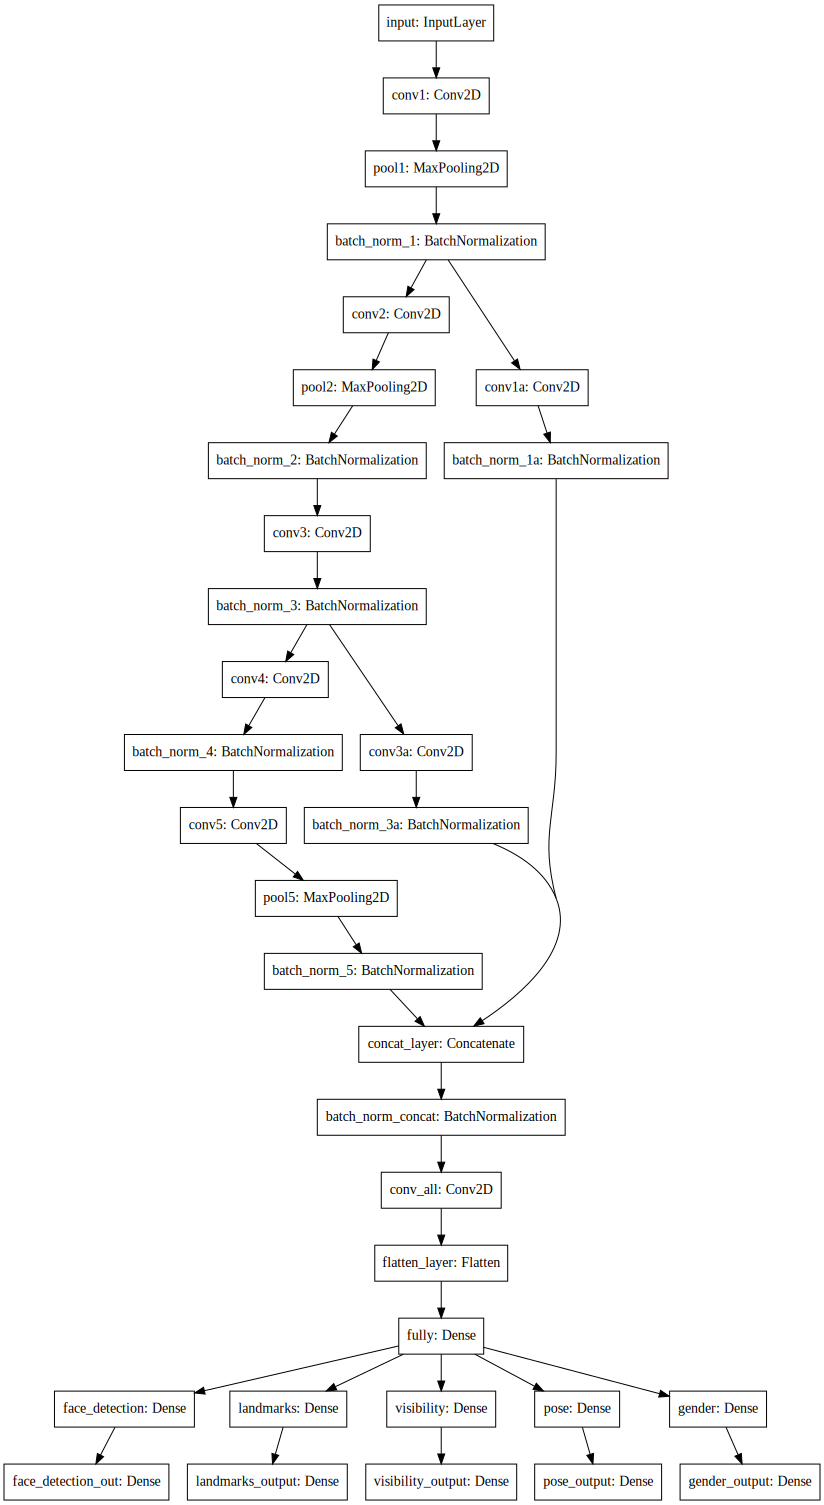

In [60]:
SVG(model_to_dot(hyperface_model).create(prog='dot', format='svg'))

#### Initialize the weights of hyperface layers with face detection layer weights

In [61]:
def initialize_weights_of_hyperface_with_face_detection_layer_weights(alex_layers):
    for layer in alex_layers:
        print(layer)
        hyperface_model.get_layer(layer).set_weights(face_model.get_layer(layer).get_weights())
    print('done')

#### Return the common layer name in both models

In [62]:
def return_common_layers_name(hyperface_model, face_detection_model):
    return {layer.name for layer in hyperface_model.layers}.intersection({layer.name for layer in face_detection_model.layers})


In [63]:
initialize_weights_of_hyperface_with_face_detection_layer_weights(return_common_layers_name(face_model,hyperface_model))

batch_norm_5
batch_norm_4
pool1
conv2
batch_norm_3
batch_norm_1
pool2
conv1
batch_norm_2
pool5
conv3
conv4
conv5
done


#### Check if weights of conv5 layer of both networks are same


In [64]:
print(face_model.get_layer('conv5').get_weights())

[array([[[[ 0.02073741,  0.00227066, -0.01527119, ...,  0.0178237 ,
           0.0297473 ,  0.02632949],
         [ 0.02186719,  0.01887723, -0.02889281, ...,  0.03280214,
          -0.0016997 , -0.00808418],
         [ 0.01047747,  0.02456422, -0.02435084, ...,  0.01796716,
           0.00741496,  0.01785267],
         ...,
         [-0.01236947,  0.02183303,  0.00174717, ..., -0.02466114,
          -0.01352911,  0.0099483 ],
         [ 0.00010387,  0.00519016,  0.02242031, ...,  0.03186608,
          -0.0275053 , -0.01858447],
         [ 0.00863673, -0.00801409,  0.00347543, ..., -0.00374245,
           0.03181   ,  0.02546834]],

        [[-0.02611273,  0.00445519,  0.00330424, ..., -0.02706695,
           0.02290761, -0.00734982],
         [-0.02837772,  0.00616777,  0.0184495 , ..., -0.02614733,
          -0.01779686, -0.00498914],
         [-0.02253348, -0.0246785 ,  0.01911125, ...,  0.02449184,
          -0.01882737, -0.02536552],
         ...,
         [ 0.01793127, -0.0157861

In [65]:
print(hyperface_model.get_layer('conv5').get_weights())

[array([[[[ 0.02073741,  0.00227066, -0.01527119, ...,  0.0178237 ,
           0.0297473 ,  0.02632949],
         [ 0.02186719,  0.01887723, -0.02889281, ...,  0.03280214,
          -0.0016997 , -0.00808418],
         [ 0.01047747,  0.02456422, -0.02435084, ...,  0.01796716,
           0.00741496,  0.01785267],
         ...,
         [-0.01236947,  0.02183303,  0.00174717, ..., -0.02466114,
          -0.01352911,  0.0099483 ],
         [ 0.00010387,  0.00519016,  0.02242031, ...,  0.03186608,
          -0.0275053 , -0.01858447],
         [ 0.00863673, -0.00801409,  0.00347543, ..., -0.00374245,
           0.03181   ,  0.02546834]],

        [[-0.02611273,  0.00445519,  0.00330424, ..., -0.02706695,
           0.02290761, -0.00734982],
         [-0.02837772,  0.00616777,  0.0184495 , ..., -0.02614733,
          -0.01779686, -0.00498914],
         [-0.02253348, -0.0246785 ,  0.01911125, ...,  0.02449184,
          -0.01882737, -0.02536552],
         ...,
         [ 0.01793127, -0.0157861

## Hyperface Callbacks

In [68]:
def hyperface_callbacks():
    path_checkpoint = 'hyperface_checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=1,
                                          save_weights_only=True, save_best_only=True)

    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    log_dir = 'hyperface_logs'
    callback_tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)
    return [callback_checkpoint, callback_early_stopping, callback_tensorboard]

## Define Data Generator

In [69]:
def generator(x, y, batch_size=32):
    data_size = x.shape[0]
    while True:
        batch_start = 0
        while batch_start < data_size:
            batch_x = x[batch_start:batch_start + batch_size, :, :]
            batch_f = y[0][batch_start:batch_start + batch_size]
            batch_l = y[1][batch_start:batch_start + batch_size, :]
            batch_v = y[2][batch_start:batch_start + batch_size, :]
            batch_p = y[3][batch_start:batch_start + batch_size, :]
            batch_g = y[4][batch_start:batch_start + batch_size, :]
            batch_start += batch_size
            yield batch_x, [batch_f, batch_l, batch_v, batch_p, batch_g]

### Train hyperface model


In [ ]:
callbacks = hyperface_callbacks()
labels = [y_Face, y_Landmarks, y_Visibility, y_Pose, y_Gender]
hyperface_model.fit_generator(generator(X_train, labels), steps_per_epoch=32,
                                 epochs=2, callbacks=callbacks)

Epoch 1/2
 3/32 [=>............................] - ETA: 4:23 - loss: 4.7807 - face_detection_out_loss: 0.6931 - landmarks_output_loss: 0.0847 - visibility_output_loss: 0.1630 - pose_output_loss: 0.5986 - gender_output_loss: 0.2949 - face_detection_out_acc: 0.6562 - landmarks_output_acc: 0.0625 - visibility_output_acc: 0.0625 - pose_output_acc: 0.2604 - gender_output_acc: 0.2188

In [ ]:
hyperface_model.save('hyperface_model.h5')

### Make Predictions

In [ ]:
def prediction_hyperface(images):
    predictions = hyperface_model.predict(images)
    return predictions